<a href="https://colab.research.google.com/github/ggwnsghgg/Exchange_rate_prediction_Project/blob/main/%ED%99%98%EC%9C%A8_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%8B%A4%EB%B3%80_LSTM_%EC%A7%84%ED%96%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os 
import pandas as pd
from google.colab import files
import warnings
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import concatenate
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.utils import np_utils


warnings.simplefilter('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
myfile = files.upload()

Saving test.csv to test.csv


In [3]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('test.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,"1,099.70",6764.11,0.87,NaN,90.95,0.47,"3,133.73"
1758,2021.02.18,"1,107.70",6652.76,0.87,NaN,90.59,0.49,"3,086.66"
1759,2021.02.19,"1,105.70",6712.32,0.86,NaN,90.36,0.51,"3,107.62"
1760,2021.02.22,"1,107.10",6635.92,0.86,NaN,90.01,0.50,"3,079.75"
1761,2021.02.23,"1,106.50",6607.24,0.86,NaN,90.17,0.49,"3,070.09"


In [4]:

#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","KRX100", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))

In [5]:
#천단위 쉼표 제거
df1['ExchangeRate'] = df1['ExchangeRate'].str.replace(',','')
df1['KOSPI'] = df1['KOSPI'].str.replace(',','')
df1.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.70,6764.11,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.70,6652.76,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.70,6712.32,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.10,6635.92,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.50,6607.24,0.86,NaN,90.17,0.49,3070.09


In [6]:

#오브젝트형 데이터 실수로 형변환
df1["KOSPI"] = pd.to_numeric(df1.KOSPI, errors='coerce')
df1["ExchangeRate"] = pd.to_numeric(df1.ExchangeRate, errors='coerce')

In [7]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     1
KRX100           6
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [8]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

df_intp.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.7,6764.11,0.87,0.0815,90.95,0.47,3133.73
1758,2021.02.18,1107.7,6652.76,0.87,0.0815,90.59,0.49,3086.66
1759,2021.02.19,1105.7,6712.32,0.86,0.0815,90.36,0.51,3107.62
1760,2021.02.22,1107.1,6635.92,0.86,0.0815,90.01,0.50,3079.75
1761,2021.02.23,1106.5,6607.24,0.86,0.0815,90.17,0.49,3070.09


In [9]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

In [10]:
df_intp.head()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


In [11]:
#날짜가 인덱스인 경우도 생성 해놓자
df_date = df_intp.set_index('Date')
df_date.head()

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


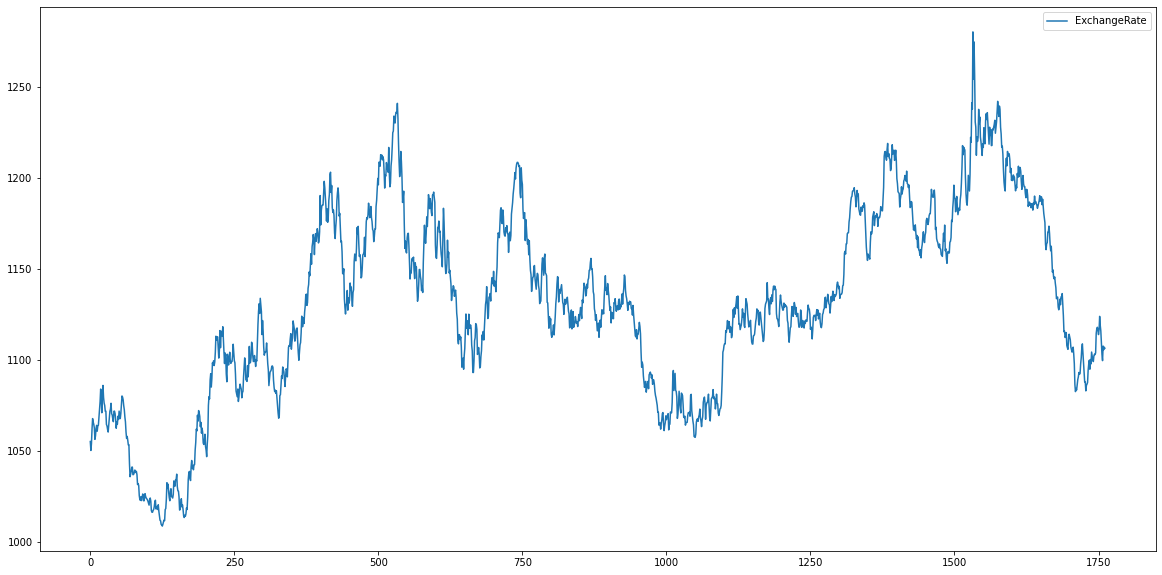

In [12]:
#시각화 해보자
df_intp.plot(y='ExchangeRate',figsize = (20,10))

In [13]:
from sklearn.preprocessing import MinMaxScaler

#scaler 객체 생성
scaler = MinMaxScaler()

#데이터셋 변환
scaler.fit(df_date)
date_scaler = scaler.transform(df_date)

#transform 변환을 하면 배열 형식으로 바뀌는데 그걸 다시 데이터 프레임 형식으로 넘기자
df_scaler = pd.DataFrame(date_scaler, columns = df_date.columns, index = df_date.index)
df_scaler

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,0.171091,0.277568,1.000000,0.019069,0.064449,0.995215,0.290947
2014-01-03,0.153024,0.262975,1.000000,0.018814,0.071518,0.990431,0.278928
2014-01-06,0.166667,0.266208,0.995025,0.018601,0.065281,0.980861,0.283005
2014-01-07,0.196534,0.269393,0.985075,0.017793,0.072349,0.990431,0.286522
2014-01-08,0.217552,0.269182,0.985075,0.017751,0.079834,0.985646,0.286248
...,...,...,...,...,...,...,...
2021-02-17,0.334808,0.945766,0.049751,0.013074,0.486902,0.019139,0.957027
2021-02-18,0.364307,0.916010,0.049751,0.013074,0.471933,0.028708,0.930151
2021-02-19,0.356932,0.931926,0.044776,0.013074,0.462370,0.038278,0.942119


In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [49]:
reframed = series_to_supervised(df_scaler, 1, 1) #t-1시점,t시점 데이터를 한 행으로 둔다

In [50]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
Date,,,,,,,,,,,,,,
2014-01-03,0.171091,0.277568,1.000000,0.019069,0.064449,0.995215,0.290947,0.153024,0.262975,1.000000,0.018814,0.071518,0.990431,0.278928
2014-01-06,0.153024,0.262975,1.000000,0.018814,0.071518,0.990431,0.278928,0.166667,0.266208,0.995025,0.018601,0.065281,0.980861,0.283005
2014-01-07,0.166667,0.266208,0.995025,0.018601,0.065281,0.980861,0.283005,0.196534,0.269393,0.985075,0.017793,0.072349,0.990431,0.286522
2014-01-08,0.196534,0.269393,0.985075,0.017793,0.072349,0.990431,0.286522,0.217552,0.269182,0.985075,0.017751,0.079834,0.985646,0.286248
2014-01-09,0.217552,0.269182,0.985075,0.017751,0.079834,0.985646,0.286248,0.210546,0.260407,0.980100,0.017496,0.079002,0.985646,0.278911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-17,0.347345,0.966433,0.049751,0.013074,0.468607,0.033493,0.973883,0.334808,0.945766,0.049751,0.013074,0.486902,0.019139,0.957027
2021-02-18,0.334808,0.945766,0.049751,0.013074,0.486902,0.019139,0.957027,0.364307,0.916010,0.049751,0.013074,0.471933,0.028708,0.930151
2021-02-19,0.364307,0.916010,0.049751,0.013074,0.471933,0.028708,0.930151,0.356932,0.931926,0.044776,0.013074,0.462370,0.038278,0.942119


In [59]:
values = reframed.values
n_train_hours = 600 #1년치 데이터만 가져온다
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [60]:
test_X.shape

(1161, 1, 13)

In [61]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [62]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
9/9 - 3s - loss: 0.0791 - val_loss: 0.1100
Epoch 2/50
9/9 - 0s - loss: 0.0239 - val_loss: 0.0516
Epoch 3/50
9/9 - 0s - loss: 0.0046 - val_loss: 0.0340
Epoch 4/50
9/9 - 0s - loss: 0.0034 - val_loss: 0.0321
Epoch 5/50
9/9 - 0s - loss: 0.0027 - val_loss: 0.0335
Epoch 6/50
9/9 - 0s - loss: 0.0015 - val_loss: 0.0374
Epoch 7/50
9/9 - 0s - loss: 0.0015 - val_loss: 0.0393
Epoch 8/50
9/9 - 0s - loss: 0.0015 - val_loss: 0.0383
Epoch 9/50
9/9 - 0s - loss: 0.0014 - val_loss: 0.0370
Epoch 10/50
9/9 - 0s - loss: 0.0013 - val_loss: 0.0366
Epoch 11/50
9/9 - 0s - loss: 0.0013 - val_loss: 0.0369
Epoch 12/50
9/9 - 0s - loss: 0.0012 - val_loss: 0.0372
Epoch 13/50
9/9 - 0s - loss: 0.0012 - val_loss: 0.0369
Epoch 14/50
9/9 - 0s - loss: 0.0012 - val_loss: 0.0366
Epoch 15/50
9/9 - 0s - loss: 0.0012 - val_loss: 0.0362
Epoch 16/50
9/9 - 0s - loss: 0.0012 - val_loss: 0.0360
Epoch 17/50
9/9 - 0s - loss: 0.0011 - val_loss: 0.0357
Epoch 18/50
9/9 - 0s - loss: 0.0011 - val_loss: 0.0354
Epoch 19/50
9/9 - 0

In [63]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


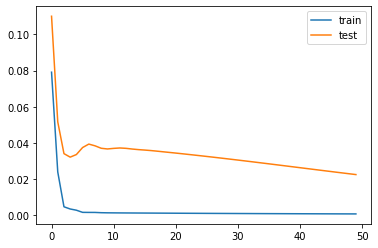

In [64]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

ValueError: ignored

In [ ]:
train_size = int(0.8 * len(df_scaler))
train = df_scaler.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(df_scaler.iloc[:train_size, [0,1,2,3,4,5,6]]),pd.DataFrame(df_scaler.iloc[:train_size, 0])
x_test, y_test = pd.DataFrame(df_scaler.iloc[train_size:, [0,1,2,3,4,5,6]]), pd.DataFrame(df_scaler.iloc[train_size:, 0])

x_test.head()